# 概述

## 目前主流的推荐广告算法架构体系是一个召回排序的两阶段流程，
https://zhuanlan.zhihu.com/p/126282487

    召回模块从海量的候选池中召回多样的相关的候选物料，
    排序模块根据用户偏好和上下文信息给出用户最可能感兴趣的一个有序列表。

随着深度学习技术的普及，越来越多的深度学习算法被应用到了工业界中。笔者自去年毕业进入企业后，有幸参与了某新业务的推荐系统搭建以及用户体验和业务指标的优化当中，其中在召回部分也进行过一些基于向量召回的探索并取得了一些收益。

之前在读研期间出于个人兴趣开发过一个基于深度学习的点击率预测算法库DeepCTR(https://github.com/shenweichen/DeepCTR)，随着时间的迭代得到了一些同学的支持和认可，自己也亲身使用到了里面的算法应用到了自己的业务当中并取得了显著的收益。

相比于排序中各种点击率预估模型，自己对于召回模块的了解还有很多欠缺，借着这个机会，抱着学习的心态，和几位热心的优秀小伙伴一起做了DeepMatch这个项目，希望它能够帮助到大家！

### 推荐系统整体架构
![](imgs/rs01.jpg)

# 数据
推荐系统的数据分为3类
## user画像user feat
## item画像item feat
## user click item sequence
通过sequence数据可以提取出热度信息，时序信息和矩阵
### 热度信息
#### 活跃user
#### 热度商品
### 时序统计信息
#### 近n日点击次数
#### 基于时间窗window统计信息
### matrix
通过sequence数据可以提炼出如下3类matrix。

注意: 提炼matrix数据会丢失sequence的顺序信息!!!
#### user_item matrix
#### user_user matrix
#### item_item matrix
item共现矩阵

# 召回matching | Recall
常见的召回思路
![](imgs/rsm01.png)

## 规则
### 热度
如 召回 热度排名TopN

## 矩阵
### user_item matrix
可以通过计算cosine sim得到 user sim和 item sim
### item_item matrix
item共现矩阵。描述两个item同时被点的次数，次数越多，两个item相关性越大！
### user_user matrix
user共现矩阵，还没有遇到。。。好像没什么用！用法可以参考item_item matrix
### 矩阵分解 Matrix Factorization

#### svd
#### 基于FM模型召回
见下文

### 关联规则Association rules
Apriori

### 其它
Bipartite network

# 深入理解YouTube推荐系统算法
https://zhuanlan.zhihu.com/p/114703091

https://link.zhihu.com/?target=https%3A//static.googleusercontent.com/media/research.google.com/zh-TW//pubs/archive/45530.pdf

## 系统结构

* 第一部分 召回网络(Matching)：  
此阶段主要目的是从百万级的视频中检索出一小部分的视频用于之后的排序操作，这部分需要处理的数据量非常大，速度要求快，所有使用的模型和特征都不能太复杂。召回网络会根据用户的历史信息（比如用户的历史观看、搜索等）进行召回，
这一阶段召回的视频满足用户泛化的兴趣，__用户之间的相似度则通过粗略的特征来表示，如用户观看视频的ID，搜索query和用户画像__。

* 第二部分 排序网络(Ranking)：  
此阶段会使用更加丰富和精细的用户和视频特征，预测用户对召回的视频打分，然后根据分数进行排序，依次展示给用户。这部分最主要是能够精准的将视频推送给用户，所以需要更加复杂的模型和特征来提升推荐效果。

* 第三部分 线下评估：  
评估指标有precision、recall、ranking loss等，最终的效果还是需要线上做A/B测试，关注的指标包括：点击率、观看时间等；需要指出的是，线上线下有时候并不能保持一致的结果。

接下来一起看看Matching和Ranking的具体设计思路，同时会给出具体实现代码，帮助加深理解算法原理。在介绍召回模型前，先看看传统的召回思路。

## matching

### 传统召回思路

先离线计算好商品的Embedding以及用户的Embedding，线上召回的时候，根据用户的Embedding去和所有商品的Embedding内积，找出TopN。这种传统的方式需要解决以下几个问题：

    商品的Embedding空间和用户的Embedding空间如何保证在同一个空间。
    需要计算与所有商品的内积，存在性能问题。
    诸如奇异值分解的方法，输入协同矩阵，特征比较单一

During candidate generation, the enormous YouTube cor-pus is winnowed down to hundreds of videos that may berelevant to the user.  The predecessor to the recommender described here was a matrix factorization approach trainedunder rank loss [23].  Early iterations of our neural networkmodel  mimicked  this  factorization  behavior  with  shallownetworks that only embedded the user’s previous watches.From this perspective, our approach can be viewed as a non-linear generalization of factorization techniques.


3.1    Recommendation as ClassificationWe pose recommendation as extreme multiclass 


To efficiently train such a model with millions of classes, werely on a technique to sample negative classes from the back-ground distribution (“candidate sampling”) and then correctfor this sampling via importance weighting [10]. For each ex-ample the cross-entropy loss is minimized for the true labeland the sampled negative classes.  In practice several thou-sand negatives are sampled, corresponding to more than 100times speedup over traditional softmax.  A popular alterna-tive  approach  is  hierarchical  softmax  [15],  but  we  weren’t able  to  achieve  comparable  accuracy.   In  hierarchical  soft-max, traversing each node in the tree involves discriminat-ing between sets of classes that are often unrelated, makingthe classification problem much more difficult and degradingperformance

## Ranking

召回阶段已经给出了候选集，在排序阶段，其目的是对给定的小规模候选集进行精细化的排序。通常，排序阶段还涉及对多个不同召回源的视频进行有效集成，这给排序阶段增加了难度。

### FE
![](imgs/rf01.png)
![](imgs/rf02.png)

* 画像特征: age, gender
* 序列特征: 
    *商品序列: 用户最近的n个序列
    *时间序列: 用户最近点击item的时间或时间差
* 统计特征

### 模型融合
![](imgs/rf03.png)

# 召回
https://zhuanlan.zhihu.com/p/115690499

召回是推荐系统的第一阶段，主要根据用户和商品部分特征，从海量的物品库里，快速找回一小部分用户潜在感兴趣的物品，然后交给排序环节。

这部分需要处理的数据量非常大，速度要求快，所有使用的策略、模型和特征都不能太复杂。下面主要介绍四种常见的召回方法：

* 基于内容的召回：使用item之间的相似性来推荐与用户喜欢的item相似的item。

例如：如果用户A看了《绣春刀2》这部杨幂主演的电影后，则会为他推荐杨幂主演的其他电影或电视剧

* 协同过滤：同时使用query和item之间的相似性来进行推荐。

例如：如果用户A与用户B类似，并且用户B喜欢视频1，则系统可以向用户A推荐视频1（即使用户A尚未看过任何与视频1类似的视频）。

* 基于FM模型召回：FM是基于矩阵分解的推荐算法，其核心是二阶特征组合。
* 基于深度神经网络的方法：利用深度神经网络生成相应的候选集。

## 基于内容的召回
![](imgs/rs02.jpg)
基于内容的召回（ CB召回 ），一般也叫做标签召回。

当谈起CB的时候，大家可能会觉的很简单，用tag或者用cate召回就行了，好像没什么可做的。可事实上，CB并不仅仅是用tag和cate做个倒排就搞定了。

这类召回的核心思想是基于item自身的属性，这些属性可以表达为tag，Cate，也可以用来表达用户ID，用户类型等，更可以通过⼀些交叉验证的⽅式，针对内容提取向量，将内容表达为连续向量的方式进行召回。接下来我们进一步来理解基于内容的过滤。

在实际的应用中，如电影推荐，首先我们根据用户之前的历史行为信息（如点击，评论，观看等），CB会使用item相关特征来推荐给用户与之前喜欢的item类似的item。为了更形象的表示CB，假设一个应用商店要推荐给用户相应的APP。下图是相应的特征矩阵，其中每一行代表一个应用程序，每一列代表一个特征。包括不同的类别特征，应用程序的发布者信息等。为简化起见，假定此特征矩阵是布尔类型的的：非零值表示应用程序具有该特征。
![](imgs/rs03.jpg)

还可以在同一特征空间中表示用户。一些与用户相关的特征可以由用户明确提供。例如，用户在其个人资料中选择“娱乐应用”。其他特征可能是隐式的，具体取决于它们先前安装的应用程序。例如，用户安装了由Science R Us发布的另一个应用程序。

模型应推荐与此用户有关的item。为此，必须首先选择一个相似性指标（如，点积）。然后，推荐系统会根据此相似性度量标准为每个候选item打分。
#### 请注意，建议是针对该用户的，因为该模型未使用其他用户的任何信息。

### 基于内容召回的优点

    该模型不需要其他用户的任何数据，因为推荐是针对该用户的。 这使得更容易扩展到大量用户。该模型可以捕获用户的特定兴趣。

### 基于内容召回的缺点

    由于item的特征表示在某种程度上是手工设计的，因此该技术需要大量领域知识。因此，模型很依赖手工设计特征的好坏。该模型只能根据用户的现有兴趣提出建议。换句话说，该模型扩展用户现有兴趣的能力有限。

基于内容的召回看似比较容易，如果当我们的item属性越来越多的时候，比如⼀个视频可能有多个平行的tag以及其它属性，那么，为了把这些信息综合利用起来，我们还会利用多term检索的方式，去提升CB的效果。下面，我们针对这些内容详细的来聊⼀聊
### CB的常见优化点。

2.3 倒排优化

优化倒排的主要目的是提升cb召回的推荐效果，常见的倒排基本是和线上排序指标⼀致的，比如，如果排序的指标是点击率，倒排理所应当，也是点击率。但这样的排序方式有个小问题，因为倒排排序使用的是后验的值，而排序通常也是单指标排序，这样，就很容易出现我们之前提到的，单指标被hack的问题，比如，用点击率倒排，头部都是标题党等。所以，这个问题是需要额外注意的。另外，也要考虑指标的bias的问题，例如，用完成率倒排导致短的视频都排到了头部。这种问题可以通过归一化的方式缓解。但有⼀个潜在风险，资源的后验表现的分布往往会跟资源本身的类型有关。

2.4 触发key的优化

key的优化要求只有⼀点，保证每次选择的key，是用户点击概率最⼤的key即可，所以通用的方式是把用户的点击历史按照属性加和取top，比如，在某个类别上点击的次数排序，把点击次数最多的那几个类别留作触发的key，这个过程很简单，没太多优化点，我们就不继续讨论了。这⾥想聊的是关于用户不⼀样的行为差异化权重的问题，我们选取key的过程实际是判断用户对某⼀类内容感兴趣的过程，也就是通过行为，来判断用户的感兴趣程度，在只有浏览功能的产品⾥，点击就是表达用户兴趣的唯一行为，但产品通常会设计很多交互功能，来帮助用户进行有效的兴趣表达，所以，在触发key的选取的时候需要考虑到这⼀点，至于怎么做是和业务形态相关的事，这⾥就不展开了。

2.5 多维度内容属性

最后，我们来讲⼀下cb⾥⾯比较高阶的问题，多term的问题。我们先考虑这样⼀种情况，一个视频有很多个tag，tag的特性是平行不唯⼀。我们在线通过点击量汇聚得到了用户的高频点击tag，通常的方式是，每⼀个tag都会有⼀个倒排，然后各自召回。但很容易想到的，当用户同时有“帅哥”，“萌宠”这两个tag的时候，通过萌宠给用户召回⼀个美女+萌宠的视频显然没有召回⼀个帅哥+萌宠的视频更有吸引力，也就是说，我们在召回的时候，如果能同时考虑多个term之间的关系，会更有效⼀些。传统搜索⾥对于多term召回是有⼀套实现方式的，通过设置每个term的权重，可以在返回结果⾥去得到包含多term的结果，这部分属于搜索架构的内容范畴，我在此不展开了，有兴趣的同学可以找身边做搜索的同学了解⼀下。我们讲⼀个更和推荐match的方式，用户身上有多个标签，内容上面也有多个标签，我们在做多term匹配的时候，就是标签的list到标签的list，使得他们点击的概率最大即可。是不是觉得豁然开朗了？是不是转化成点击率建模问题了？更简单地，直接使用word2vec，把用户标签和内容标签作为⼀个sentence训练，再离线把内容的标签加和表征为内容的属性向量，在线做召回即可。当然，也可以⽤更复杂的⽅式来做，提升精度，大同小异，就不展开说了。那作者，内容的其他纬度等信息也是可以⼀样的方式加进去的，这就留给大家来讨论了。

## 协同过滤

为了解决基于内容的召回所存在的弊端，人们提出了协同过滤召回方式（Collaborative filtering，CF），CF同时使用user和item之间的相似性来进行推荐。 这样可以提高模型的推荐拓展性。也就是说，协同过滤模型可以根据相似用户B的兴趣向用户A推荐商品。此外，可以自动学习Embedding，而无需依赖手工设计的特征。

一般来说，协同过滤推荐分为三种类型。
* 基于用户(user-based)的协同过滤，  
基于用户(user-based)的协同过滤：主要考虑的是用户和用户之间的相似度，只要找出相似用户喜欢的物品，并预测目标用户对对应物品的评分，就可以找到评分最高的若干个物品推荐给用户。
* 基于项目(item-based)的协同过滤，  
基于项目(item-based)的协同过滤：和基于用户的协同过滤类似，只不过这时我们转向找到物品和物品之间的相似度，只有找到了目标用户对某些物品的评分，那么我们就可以对相似度高的类似物品进行预测，将评分最高的若干个相似物品推荐给用户。比如你在网上买了一本机器学习相关的书，网站马上会推荐一堆机器学习，大数据相关的书给你，这里就明显用到了基于项目的协同过滤思想。
* 基于模型(model based)的协同过滤。  
基于模型（model based）的协同过滤：是目前最主流的协同过滤类型了，所含算法是非常之多的，如矩阵分解、关联算法、聚类算法、深度学习、图模型等等。

这里我们带来一个有关电影推荐系统的简单例子帮助更好的理解协同过滤。首先，考虑一个电影推荐系统，其中训练数据由一个反馈矩阵组成，其中每行代表一个user，每一列代表一个item。

关于电影的反馈分为以下两类：

    显示反馈：用户通过提供评分来指定他们对特定电影的喜欢程度。
    隐式反馈：如果用户观看电影，则系统会推断用户感兴趣。

假设反馈矩阵是布尔类型的，即值为1和0分别表示对电影是否感兴趣，当用户访问首页时，系统会根据以下两种情况推荐电影：

    与用户过去喜欢的电影相似（Item-Based CF）
    类似用户喜欢的电影（User-Based CF）

为便于举例阐述，让我们手工设计用以描述电影的一些特征：
![](imgs/rs04.jpg)

### 一维Embedding

假设我们为每部电影分配一个标量，用于描述该电影是适合儿童（负值）还是适合成人（正值）观看。 假设我们还为每个用户分配了一个标量，用于描述用户对儿童电影（接近-1）或成人电影（接近+1）的兴趣。 对于我们希望用户喜欢的电影，电影Embedding和用户Embedding的乘积应更高（接近1）。
![](imgs/rs05.jpg)

在下图中，每个对号标记都标识特定用户观看的电影。 第三和第四用户具有的特征很好地表示了用户的偏好：第三用户偏爱儿童电影，第四用户偏爱成人电影。 但是，单个特征无法很好地表示第一和第二用户的偏好。这时候需要考虑二维甚至更高维度的特征。
![](imgs/rs06.jpg)

### 二维Embedding

一个特征不足以解释所有用户的偏好。 为了克服这个问题，让我们添加第二个特征：每部电影是商业流行片或是小众文艺片上的表现程度。 通过这个特征，我们现在可以使用以下二维Embedding来表示每部电影：

我们再次将用户放置在相同的嵌入空间中，以最好地解释反馈矩阵：对于（用户，商品）对，我们希望用户Embedding和商品Embedding的点积在用户观看商品时接近1 电影，否则为0。

在这个例子中，我们对Embedding进行了手工设计。在实践中，可以自动学习Embedding向量表示，这是协同过滤模型的强大功能。在接下来的内容中，我们将讨论学习这些嵌入表示的不同模型以及如何对其进行训练。

当模型自动学习Embedding时，这种方法的协同性质就显而易见了。假设电影的Embedding向量是固定的。然后，模型可以为用户学习Embedding向量，以最好地解释他们的偏好。 因此，具有相似偏好的用户的Embedding将紧密在一起。同样，如果用户的Embedding是固定的，则我们可以学习电影Embedding以最好地解释反馈矩阵。结果，类似用户喜欢的电影的Embedding将在Embedding空间中紧密在一起。

### 基于模型(model based)的协同过滤

矩阵分解是一个简单的Embedding模型。 给定反馈矩阵 A\in R^{mxn} ，其中 m 是用户（或query）数量， n 是item数量，该模型将学习：

    user Embedding矩阵 U \in R^{mxd} ，其中第i行是 user_i 的Embedding。
    item Embedding矩阵 V \in R^{nxd} ，其中第j行是 item_j 的Embedding。
    
![](imgs/rs07.jpg)
Embedding通过学习，使得 UV^T 的乘积是反馈矩阵 A 的良好近似。 UV^T 的 (i,j) 项就是 user_i 和 item_j 对应的两个embedding的点积，使其尽量接近 A_{ij} 。

注意：与学习完整矩阵相比，矩阵分解通常会得到更简洁的表示。 完整矩阵具有 O(nm) 项，而Embedding矩阵具有 O((n+m)xd) 项，其中Embedding维数 d 通常比 m 和 n 小得多。 最终，观测矩阵会被映射到低维子空间中，矩阵分解就可以在数据中找到其对应的潜在信息。 在前面的示例中， n ， m 和 d 的值都非常小，因此优势可以忽略不计。 但是，在现实世界中的推荐系统中，矩阵分解可以比学习整个矩阵要简洁得多。

### 选择目标函数

一种直观的目标函数是距离的平方， 即在所有观察到的矩阵项上最小化平方误差之和：
![](imgs/rs08.jpg)
在此目标函数中，只求观察到的对 (i,j) 的误差和，即对反馈矩阵中的非零值求和。 但是，只求1的误差总和并不是一个好方法。最小化矩阵中所有为1元素产生的模型，并不能进行很好的推荐，而且泛化性较差。
![](imgs/rs09.jpg)

也许可以将未观察到的值视为零，并对矩阵中的所有条目求损失和。这样其实就是最小化 A 及其近似值 UV^T 之间Frobenius距离的平方：
![](imgs/rs10.jpg)

可以通过矩阵的奇异值分解（SVD）解决此二次问题。 但是，SVD并不是一个很好的解决方案，因为在实际应用中，矩阵 A 可能非常稀疏。 例如，将抖音上所有视频与特定用户观看过的视频进行比较。 得到的解 UV^T （对应于模型对输入矩阵的近似值）可能接近于零，从而导致泛化性能较差。

相比之下，加权矩阵分解将目标分解为以下两部分的和：

    观察到的误差和
    未观察到的误差和（视作0）
    
![](imgs/rs11.png)

w_0是调节两项加权的超参，以使目标不被其中一项所支配。 调整此超参数非常重要。

在实际应用中，还需要仔细权衡观察到的数据。例如，频繁的item（如，非常受欢迎的视频）或频繁的query（例如，重度用户）可能会主导目标功能。可以通过对频繁出现的item所对应的训练样本进行加权来纠正此影响。 换句话说，您可以将目标函数替换为：
![](imgs/rs12.png)
w_ij是query i 和item j 对应的频率函数

### 最小化目标函数

最小化目标函数的常用算法包括：

    随机梯度下降（SGD）是使损失函数最小化的通用方法。
    加权交替最小二乘（WALS）专用于此特定目标函数。

在两个矩阵U和V中，每个目标都是二次的。（需要请注意的是，联合问题并不是凸的）WALS的工作方式是随机初始化Embedding，然后在以下条件之间交替进行：

    固定 U 求解 V 。
    固定 V 求解 U 。

每步都可以准确地求解（通过线性问题的解决方法）并可以进行分布式计算。 该技术可以保证收敛，因为可以确保每一步都可以减少损失。

### 3.6 SGD和WALS

下面对SGD和WALS优缺点进行比较：

SGD优点：非常灵活：适用于其他损失函数；可以并行化。

SGD缺点：较慢，收敛速度不那么快；难以处理未观察到的项（entries），需要使用负采样或gravity。

WALS优点：可以并行化；收敛速度比SGD更快；更容易处理未观察到的项（entries）。

WALS缺点：仅适用于平方损失；

### 协同过滤的优缺点

优点

    无需领域知识：不需要相关领域知识，因为Embedding是自动学习的。
    发掘用户兴趣：该模型可以帮助用户发现新的兴趣点。 系统可能并不知道用户对给定的item的兴趣度，但是模型仍会推荐给他，因为相似的用户有着相同的兴趣点。
    很好的初始模型：在某种程度上，该方法仅需要反馈矩阵即可训练矩阵分解模型。 而且该方法不需要上下文特征。 实际上，该方法可以用作多个召回队列中的一个。

缺点

    冷启动问题

模型预测结果是给定的（用户，商品）相应Embedding的点积。因此，如果在训练数据中item从未出现过，则系统也无法计算其Embedding，也无法得到相应的预测结果。此问题通常称为冷启动问题。但是，以下技术可以在某种程度上解决冷启动问题：

（1）利用WALS进行预测。给定一个在训练集中未出现的item，如果系统与用户有一些交互，则系统可以很容易计算出该item的Embedding，而无需重新训练整个模型。只需求解以下方程式或其加权形式：

上述方程对应于WALS中的一个迭代：用户Embedding保持固定，系统求解item的Embedding。对于新用户也可以这样做。

（2）启发式生成新item的Embedding。如果系统没有相应的交互信息，则系统可以通过对来自同一类别，来自同一上传者（在视频推荐中）的item的Embedding进行平均来近似其Embedding。

    难以融入query/item的附加特征

附加特征是query或itemID以外的其他特征。 对于电影推荐，附加特征可能包括国家或年龄。 融入可用的附加特征可以提高模型的效果。 尽管在WALS中融入付诸特征可能并不容易，但是WALS的泛化模型使这成为可能。

## 基于FM模型召回

FM是Steffen Rendle在2010年提出的，FM算法的核心在于特征组合，以此来减少人工参与特征组合工作。对于FM，其优势可分以下三点:

    FM能处理数据高度稀疏场景，SVM则不能；
    FM具有线性的计算复杂度，而SVM依赖于support vector。
    FM能够在任意的实数特征向量中生效。

![](imgs/rs21.jpg)
FM的数据结构如下：
![](imgs/rs22.jpg)
FM特征数据结构：User相关、Item相关、类别相关的特征、历史行为数据特征等等，最后一列可看作是User对Item评分。FM通过不同特征的组合，生成新的含义。然而，特征组合也随之带来一些问题：

    特征之间两两组合容易导致维度灾难；
    组合后的特征未必有效，可能存在特征冗余现象；
    组合后特征样本非常稀疏，如果原始样本中不存在对应的组合，则无法学习参数，那么该组合就显得无效。

虽然有这些缺点，但是也并不影响FM在广告推荐领域的地位，每个算法都有风靡一时的过去，抱着敬畏之心的态度去学习是没问题的。下面，来看看如何基于FM来做召回的。
### 具体召回过程

基于FM的召回与完全版本的FM不同，这里会放弃 U 与 I 特征组内部的二阶交互，即没有了age、gender、item_id、cate_id这样的交互，仅是进行到求解隐向量阶段。
![](imgs/rs23.jpg)
摘自“推荐系统召回四模型之：全能的FM模型”

这里是“推荐系统召回四模型之：全能的FM模型”一文中给出的极简的FM召回模型，即不考虑上下文特征。

第一步，对于某个用户，我们可以把属于这个用户子集合的特征，查询离线训练好的FM模型中这个用户对应的特征embedding向量（FM模型求解出的隐向量，即 v_i ，其长度为 k，包含 k 个描述特征的因子），然后将这个用户对应的n个特征embedding向量累加，形成这个用户的兴趣向量U，这个向量维度和每个特征的维度是相同的。

类似的，我们也可以把每个物品，其对应的物品子集合的特征，查询离线训练好的FM模型对应的特征embedding向量，然后将m个物品子集合的特征embedding向量累加，形成物品向量I，这个向量维度和每个特征的维度也是是相同的。

![](imgs/rs24.jpg)
第二步，对于每个用户以及每个物品，我们可以利用步骤一中的方法，将每个用户的兴趣向量离线算好，存入在线数据库中比如Redis（用户ID及其对应的embedding），把物品的向量逐一离线算好，存入Faiss(Facebook开源的embedding高效匹配库)数据库中，进行knn索引，然后高效检索。

第三步，当用户登陆或者刷新页面时，可以根据用户ID取出其对应的兴趣向量embedding，然后和Faiss中存储的物料embedding做内积计算，按照得分由高到低返回得分Top K的物料作为召回结果。

有关FM召回更加详细的内容：https://zhuanlan.zhihu.com/p/58160982 

### 矩阵分解和FM
![](imgs/rs25.jpg)
可以认为FM是加了特征的矩阵分解（MF），原来用户和物品侧都只有一个id特征，现在用户侧加了年龄、性别、学历等特征，物品侧加了品类、店铺等特征，然后进一步融入到FM模型后，它将所有的特征转化为embedding低维向量表达，然后用户侧的特征和物品侧特征两两矩阵分解，即两两特征embedding的内积，得到特征组合的权重。






## 基于深度神经网络模型

前文讲述了如何使用矩阵分解来学习Embedding。 矩阵分解的一些限制包括：

    使用附加特征（即queryID /itemID以外的其他特征）困难。 因此只能对训练集中存在的用户或item进行推荐。
    推荐的相关性。 正如前文所描述的那样，倾向于向所有人推荐热门item，尤其是在使用点积作为相似性度量时。 难以刻画特定的用户兴趣。

深度神经网络（DNN）模型可以解决矩阵分解的这些限制。 DNN可以轻松地融入query特征和item特征（由于网络输入层的灵活性），这可以帮助捕获用户的特定兴趣并提高推荐的相关性。

### Softmax DNN 模型

一般而言，DNN模型是利用softmax作为最后一层的输出，它会将问题视为多分类问题，其中：

    输入是用户query。
    输出是一个概率向量，其大小等于语料库中item的数量，代表与每个item进行交互的概率； 例如，点击或观看视频的可能性。

#### 输入层

DNN的输入可以包括：

    稠密(dense)特征（如，点击频率、观看时长等）稀疏(sparse)特征（如，观看视频类型、地区等）

与矩阵分解方法不同，可以添加年龄或地区等附加特征。 我们用x表示输入向量。

#### 模型结构

模型结构决定了模型的复杂性和表达性。 通过添加隐藏层和非线性激活函数（例如ReLU），模型可以捕获数据中更复杂的关系。 但是，增加参数的数量通常也会使模型更难训练且服务成本更高。 我们将用 $\psi(x)\in R^d$ 表示最后一个隐藏层的输出。

#### 输出层: 预测的概率分布

该模型通过softmax层将最后一层的输出映射到概率分布 $\hat{p}=h(\psi(x)V^T)$ ，其中：

    h 是softmax函数， 
    V 是softmax层的权重矩阵。

softmax层将分数矢量 y （有时称为logits）映射到概率分布。
![](imgs/rs31.jpg)

#### 损失函数

最后，定义用以比较以下两项的损失函数：

    \hat{p} ，softmax层的输出（概率分布）
    p，groud-truth，代表用户与之互动的item（例如，用户点击或观看的视频）。 这可以表示为归一化的muti-hot分布（概率向量）。

例如，可以使用交叉熵损失来比较两个概率分布。



#### Softmax Embedding

item_j 的概率由 [公式] 给出，其中 [公式] 是不依赖于 [公式] 的归一化常数。
换句话说， [公式] ，因此，[公式]的对数概率是（最大为加法常数）两个 [公式] 维矢量的点积，可以将其解释为query和item Embedding：

    \psi(x) 是最后一个隐藏层的输出。 我们称其为query 的Embedding。
    V_j是将最后一个隐藏层连接到输出 [公式] 的权重向量。 我们称其为item的Embedding。



### DNN和矩阵分解

在softmax模型和矩阵分解模型中，系统对于每个item学习一个Embedding向量 V 。 我们在矩阵分解中所谓的item Embedding 矩阵 V 是softmax层的权重矩阵。但是，用户query Embedding是不同的。 将不再对每个query学习一个对应的query Embedding向量，而是学习从query 特征 [公式] 到Embedding的映射 [公式] 。 因此，可以将此DNN模型视为矩阵分解的泛化，其中将query侧替换为非线性函数 [公式] 。

item特征使用

可以将相同的想法应用于item侧吗？ 也就是说，除了对每个item学习一个对应的Embedding之外，模型可以学习将item特征映射到Embedding的非线性函数吗？ 当然可以。可以使用由两个神经网络组成的双塔模型：

............

### softmax训练

前文解释了如何将softmax层合并到推荐系统的深度神经网络中。 下面介绍如何利用训练数据对模型参数进行求解。

训练数据

训练数据由query特征 x 和与用户进行交互的item向量组成（表示为概率分布 p ）。在下图中，标记为蓝色。 模型的变量是不同层中的权重。 在下图中，标记为橙色。 通常使用随机梯度下降相关方法来训练模型。

## 更多召回模型

### Youtube DNN召回：
YouTube在2016年发表的论文《Deep Neural Networks for YouTube Recommendations》为背景进行YouTube的深度神经网络推荐模型的介绍。YouTube的dnn matching召回，将用户和context特征输入DNN，用隐含层最后一层作为向量表示，用Softmax每个item对应的参数作为item的向量表示，通过内积最大索引得到top k

论文地址：Deep Neural Networks for YouTube Recommendations

### DSSM语义召回：
DSSM模型是微软2013年发表的一个关于query/ doc的相似度计算模型，后来发展成为一种所谓”双塔“的框架广泛应用于广告、推荐等领域的召回和排序问题中。

论文地址：Learning Deep Structured Semantic Models for Web Search using Clickthrough Data

### RNN序列召回：
基于用户session中的点击序列进行建模召回有很多种方式，其中使用RNN深度网络结构来刻画是其中比较有代表性的一种。相应的网络结构其实很简单，如下图所示。使用用户session中的点击序列作为模型输入，输出则为用户下次点击的item相应的得分。

论文地址：Session-based recommendations with recurrent neural networks

### TDM深度树匹配召回：
TDM模型是阿里巴巴于2018年提出的新一代深度召回模型，试图通过结合树结构搜索与深度学习模型来解决召回的高性能需求与使用复杂模型进行全局搜索与之间的平衡。它将召回问题转化为层级化分类问题，借助树的层级检索可以将时间复杂度降到对数级。即认为用户对某节点的兴趣是大于等于其叶子节点的，所以只需在每层选出topk，且在下一层仅计算上一层选出来的节点相应子节点的兴趣，对于规模为M的语料库，只需要遍历 2 * k * logM个分支就可以在完全二叉树中找到topk的推荐结果。

论文地址：Learning Tree-based Deep Model for Recommender Systems
参考文献

    https://zhuanlan.zhihu.com/p/34497989 https://developers.google.cn/machine-learning/recommendation https://zhuanlan.zhihu.com/p/58160982 https://zhuanlan.zhihu.com/p/87578318 

# 排序
https://zhuanlan.zhihu.com/p/138235048

作为【推荐系统】系列文章的第三篇，将以“排序”作为今天的主角，会从四个方面来介绍推荐系统中的排序模块，即建模目标、样本与特征、常见模型和粗排与精排的方法。

最近正好在做KDD Cup：Debiasing赛道，不同于其它类型的比赛，推荐系统中的排序建模需要大家自己构建正负样本。本文也将作为方法梳理，希望能帮助到大家。
## 概述
排序是推荐系统的第二阶段，从召回阶段获得少量的商品交给排序阶段，排序阶段可以融入较多特征，使用复杂模型，来精准地做个性化推荐。排序所强调的是快和准，快指的是高效的反馈结果，准指的是推荐结果准确性高。

具体地，在生成候选对象之后，另一个模型会对生成的候选对象进行打分和排序，得到最后要推送的item列表。 推荐系统可能具有使用不同来源的多个召回队列，例如：

    * 矩阵分解模型的相关item。
    * 根据各类标签下的用户item。
    * “本地”与“非本地”项目； 也就是说，要考虑地理信息。
    * 热门或流行item。
    * 社交网络； 也就是朋友喜欢或推荐的item。

系统将这些不同的来源组合成一个通用的候选库，然后由单个模型对其进行打分并根据该分数进行排名。 例如，系统可以根据以下特征训练模型以预测用户观看视频的概率：

    查询特征（例如，用户观看记录，语言，国家/地区，时间）
    视频特征（例如标题，标签，视频Embedding）

然后，系统可以根据模型的预测对候选库中的视频进行排序。

## 建模目标

排序的目标是根据业务目标来不断变化的，最早期，业务目标简单，需要聚焦的时候，往往会选取⼀个指标来重点优化，当做到中期的时候，就会发现单⼀指标对整体的提升已经非常有限了，或者说会出现很多问题，这个时候，往往就会引入多目标排序来解决这些问题。

另一个方面，pointwise、pairwise和listwise本身它们都属于排序目标的一部分，但通常会认为它们也属于不同模型，我们放到后面再讲。我们以小视频自身的排序目标发展来说明排序目标的意义和如何根据业务需求，改进排序目标。
### pointwise、pairwise和listwise
![](imgs/rpx01.png)

常用的排序算法框架有pointwise、pairwise、listwise三类，上图中x1，x2，... 代表的是训练样本1，2，... 的特征，y1，y2，s1，... 等是训练集的label(目标函数值)。
* pointwise学习单个样本，如果最终预测目标是一个实数值，就是回归问题，如果目标是概率预测，就是一个分类问题，例如CTR预估。
* pairwise和listwise分别学习一对有序对和一个有序序列的样本特征，考虑得更加精细。

在推荐系统中常用pointwise方法来做排序，它更直观，易于理解，也更简单。

### 回归方式预估完成率

这里以小视频业务为例，小视频的业务形态与短视频有很大的不同，由于全屏滑动这一形态的引入从而会面临传统点击率预估之外的建模问题，也就是完成率建模。不一样的完成率代表着用户不一样的满意程度，那自然而然的想法就是把完成率这个连续值作为目标来预估，那么，我们的问题就变成了⼀个回归问题了，看似完美解决了我们的问题。而实际实验的效果却和预期的大相径庭，其原因还得做进一步讨论。

### 多目标排序

我们上述说的都是单目标排序的各种建模方式，随着业务的发展，我们会发现单目标排序迭代对系统的提升越来越有限了。一般多目标是学点击，时长，消费，点赞，评论，分享等，模型能确实学到的输出是有切实含义的，
* 比如点击的概率，观看的时长，用户到底会花多少钱等。
* 比如我们以完成率建模，短视频的完成率天生就要比长视频要高；作者会想办法发各种骗完成率的视频，类似列表页产品形态中的标题党，
* 比如，猜谜类视频等。

这些问题反映了单指标建模的脆弱性，所以，多目标建模的鲁棒性就由此凸显出来了。而多目标建模中难点在于如何平衡多个建模目标之间的关系，目前的通用做法是将多个q加权或连乘，比如Prob(click) * watch_time，也就是人工的去制定规则，这种方式可以快速见效、简单、快捷，而且便于理解。但⼀个很致命的问题是，人工规则没办法挑选出最优的解。其次，当其中的⼀个因⼦发生变化时，比如值域发生变化，就会导致整体的公式失效。如何系统的去解决这两个问题，是多目标建模中的重点和难点。
![](imgs/rpx02.png)
值得注意的是，Google在RecSys 2019上的最新论文《Recommending What Videoto Watch Next: A Multitask Ranking System》。该论文是youtube上实践的一篇文章，并且内容应该比较实用。论文本身虽然没有提出特别新颖的结构，但内容很实在，也 work，算是推荐系统中排序模块很通俗易懂的文章了，论文主要聚焦于大规模视频推荐中的排序阶段，介绍一些比较实在的经验和教训。

提出了一套大规模多目标排序框架应用于Youtube视频推荐，引入MMoE解决多目标学习，以及解决用户隐式反馈中的selection Bias问题。

## 样本与特征

我们先来说说样本，样本与模型有什么关系呢，形象化的理解样本是模型的养料，一个模型能够得到很好的结果，很大一部分成程度上是由样本的质量决定的。当然，不同的业务数据量，样本的质量通常存在很大的差异，所以，
#### 在样本上我们的问题就变成了如何根据业务目标，构造合适的样本并加以使用。
我们再来看看特征，
#### 特征是用来刻画样本的维度，没有特征，样本就只有一个label，
只有看到了特征，我们才能理解样本长得什么样。这也是为什么要办样本和特征放在一起讨论的原因。

理论上，模型学习的空间是样本空间，而我们理想建模的空间是真实空间。如果样本是真实空间的无偏采样，那么，在样本足够充足的情况且模型足够强大的情况下，我们是能学习到真实分布的。但很遗憾，我们很难去评估样本的采样是否是无偏的，模型也并不是那么强大。所以，当我们模型训练完之后，测试集的error实际就是样本能力和模型学习能力的两部分error的加和。模型的学习能力通常根据模型的差异，是相对固定的。比如，svm就是比lr误差要小。所以，在模型选型的大方向上，大家都是差不多的。真正比拼的实际就是算法工程师做 样本和做特征的能力。

那么，什么是合适的样本呢？合适的样本是符合业务产出逻辑，同优化目标⼀致的单元。举个例子，我要训练一个点击率模型，那么一条样本就是一个展现或者点击的记录。如果我要训练一个留存模型，那么，样本就是这个用户前一天看了哪些记录，他们合并作为一个样本。也就是说，样本的定义不是一成不变的，而是根据业务目标，人为构造的，但是这个构造方式是要在逻辑上和业务目标融洽的。如果你要训练一个留存模型，把用户前一天搜索的关键词作为样本，那么，可能就不是那么融洽了。
#### 样本的构造是一个看起来很容易，但是缺很难做的工作，它需要对业务很深刻的理解，才能发掘出有效的样本构造方式。

说完样本，我们再来看看特征。

#### 大部分做模型的同学实际都是做特征，特征的收益还是蛮高的。

### 特征工作的基本思路是，
人工预判有效特征->离线评估重要度和覆盖率->训练模型离线评估->在线实验。

总的来说在比较低的层面，充斥着大量的数据清洗工作和ETL（Extraction-Transformation-Loading）工作，但从长远看，特征工程的优劣决定了模型的上限，早期的lr，模型并没有多复杂，但是却被业内使⽤多年，就是因为其中汇聚了特征工程的大量经验和高效性。

特征工程发展到现在，想要带来比较大的提升的特征往往是根据业务场景的session行为精心设计的特征，比如常见的退场特征，搜索特征等。这些特征同样需要⼯程师对业务的深刻理解以及对用户行为的细致研究。

#### 深度学习带来的⼀波红利就是特征提取的自动化，
但是在推荐系统中，业务场景的复杂程度要远远高于cv等常见特征自动提取场景。所以，特征工程的存在还是有其必要性的，特别是一些高级特征。

### 常见基础特征

用户侧的特征，如用户的性别、年龄、地域、购买力、家庭结构等。

商品侧的特征，如商品描述信息、价格、标签等。

上下文及场景特征，如位置、页面、是否是周末节假日等。

交叉特征，如用户侧特征与商品侧特征的交叉等。

用户的行为特征，如用户点击、收藏、购买、观看等。

## 常见模型

推荐系统排序早期都是lr，后续演变成gbdt + lr的方式，再到后来的dnn、fm、wide & deep等。
* 排序目标上，目前业内主要还是pointwise。
* pairwise据我了解，在部分场景也有应用。
* listwise 大部分都属于调研性质的了。

另外，前段时间大火的强化学习，看起来在实际的业务 场景中，并不能很好的落地，所以，目前还没见到比较成功的应用。阿里的DIN是不错的尝试，可以找来读读。RNN系列的LSTM，seq2seq目前没看到很成功的范例。总的来说，以我 所⻅，在模型结构上想要作出出色的⼯作，是有⼀定难度的，所以，结合业务情况，可以在项目优先级上作出⼀定取舍。

### LR

lr是比较简单的线性模型，通过学习用户点击行为来构建CTR预估。利用logistic回归构建推荐算法模型，具体模型如下面公式。

$$log(\frac{p}{1-p})=\sum_{i=1}^nw_iF_i$$

其中， p 是用户喜欢某个标的物的概率； w_i 是权重，是需要学习的模型参数； F_i 是特征 i 的值。我们可以通过上述公式计算待推荐标的物的 p 值。最终我们可以按照 p 值的大小降序排列来对召回的标的物列表做排序。

在工业界，为了更好地将该模型应用到真实业务场景中，很多公司对lr模型做了推广。比如用到在线实时推荐场景中做排序，有Google在2013年推广的FTRL，以及阿里推广的分片线性模型。

### GBDT+LR

GBDT(Gradient Boosting Decision Tree)是一种基于迭代思路构造的决策树算法，该算法在实际问题中将生成多棵决策树，并将所有树的结果进行汇总来得到最终答案，该算法将决策树与集成思想进行了有效的结合，通过将弱学习器提升为强学习器的集成方法来提高预测精度。GBDT是一类泛化能力较强的学习算法。


未完待续。。。

# CIKM 2019 超大规模推荐赛道冠军比赛攻略_QDU队 top选手分享
https://tianchi.aliyun.com/notebook-ai/detail?postId=81152
## Task
数据集包括用户行为文件、用户信息文件与商品信息文件。 用户信息包含用户ID、性别、年龄与购买力，商品信息包含商品ID、类目ID、店铺ID与品牌ID（若有商品价格，有望提高推荐效果），用户行为涉及16天（由某个周五开始）的用户对商品的行为日志。

比赛要求预测一组给定用户在第17天感兴趣的商品列表。

初赛方案仅基于规则做了Match阶段，里面有些技巧，感兴趣的同学可以关注https://github.com/ChuanyuXue/CIKM-2019-AnalytiCup ，之后会在上面发布代码。 下面重点阐述复赛方案。

## EDA
数据分析与探索对方案设计有重要的指导作用。下面介绍几个关键的分析。在做EDA时，我们将数据集切分为了两部分，第1~14天日志被视为“历史”行为，第15天日志视为“未来”行为，从而可以分析对“未来”行为有重要影响的“历史”行为特点。

## 召回阶段
图5基于Item CF的召回流程
![](imgs/rm01.png)

图5给出了基于Item CF做召回的流程，先利用庞大的历史日志统计item-item相似性矩阵，再结合目标用户的历史行为做推荐。实现的难点在于对约8000万历史日志做统计的复杂度太高，需要做优化代码、做并行化处理。

如图6所示，我们将用户分为了若干组，并行处理每组内item-item共现频率的统计，最终将与每个商品最相似性的500个商品存在字典中。实际上，对复赛训练集统计后，发现字典中键值数仅有40多万。 为了提高效率，我们使用了Cpython实现统计共现频率的代码。整个流程较复杂，感兴趣的同学可以看答辩后开源的代码。
![](imgs/rm02.png)
图6 并行统计item-item相似性，并转存为字典

Item CF相似性指标关乎召回的效果。我们在实现时借鉴了2015年腾讯SIGMOD论文 [1]。在9月初，我们按照关联规则中置信度计算Item CF相似性：
$$Sim(i,j)=Confidence(i,j)=P(j|i)=\frac{|U_i\cap U_j|}{|U_i|}$$

$U_i$代表对商品i感兴趣的用户集合。 显然， Sim(i,j)!=Sim(j,i)。基于该指标做召回，线上效果为0.045。

在此基础上，我们又考虑了用户活跃度（感兴趣的商品数）对相似性的影响，改进了上述指标：
$$Sim^w(i,j)=\frac{\sum_{u\in{U}}w_u\delta(i,j)}{\sum_{u\in{U_i}}w_u}$$

其中 U是全体用户集合， Ui是对商品 i 感兴趣的用户集合；  wu 代表用户 u 对相似性的贡献度，
$$w_u=\frac{1}{log(I_u)+1}$$
$当i\in I_u且j\in I_u时，\delta(i,j)=1，否则\delta(i,j)=0。I_u代表用户u感兴趣的商品集合。当w->1时，Sim^w(i,j)等价于Sim(i,j)。$基于改进指标做召回，并做了些额外处理，线上效果为0.053。





## 排序阶段
召回阶段获得少量（300或500）候选商品后，可以构建排序模型获得最终的推荐列表。

我们将排序任务转化为二类判别问题。

在建模前，需要切分数据集。如图7所示，我们利用第1-15天数据做召回、生成特征，利用第16天的数据生成标签，从而生成线上训练集；利用1-16天数据做召回、生成特征，生成线上测试集，加载训练后的模型及相关文件完成预测。

需要特别注意的是，训练集中的正样本和负样本都是从召回列表中生成的，而不是将每个用户感兴趣的商品都拿出来做正样本。这是因为，很多用户感兴趣的商品对应的特征取值都无法统计，使得这些正样本失去了统计意义，对训练模型有负面影响。另一个赛道的亚军也是这样做的，他的解释也很好，“希望建模样本与召回样本同分布”。本赛道很多同学都未能建模做Ranking，应该是没能发现采样的技巧。

图7 排序阶段划分数据
![](imgs/rpx04.png)

图8为提取的特征列表，只有64个。其中，Item CF的相似性特征是强特征。最终使用了Catboost和Lightgbm建模。Catboost对过拟合的处理较好，使用了全部特征（线上效果为0.0616）；Lightgbm使用全部特征效果不佳，故做了特征选择，最终只使用了36个特征。
![](imgs/rpx04.png)
图8 特征列表（共64个）

为了减少特征的数量，在比赛中使用了多种特征选择方法。虽然xgboost、lightgbm、catboost可以做特征重要性分析，但很多同学可能注意到把选出的重要特征给梯度提升树模型建模并无明显提升。我们做特征选择的思路是“劣汰优胜”，先基于独立性检验剔除关联弱的特征，再从剩余特征中选择重要性高的特征。

两变量独立是指两变量既不存在线性相关性，也不存在非线性关联。我们采用Mean Variance Test[2,3]做“劣汰”，这是首都师范大学崔恒建教授2015年发表于统计领域顶刊JASA的工作，2018年进行了拓展，可用于做独立性检验及特征选择。该方法可检验一个离散型变量与一个连续型变量间是否独立，对变量的分布无假定（Distribution free），并且计算简单（只是计数）。这里仅列出其部分理论（图9），感兴趣的同学可以交流，该方法已被Chuanyu做成了工具包，已开源在他的github。此外，团队成员在IJCAI 2018和资金流入流出预测课程视频（天池AI课程，之后可能上线）中都使用Mean Variance Index做过特征选择，效果都不错。

# 推荐系统老司机的十条经验

http://www.woshipm.com/pd/480396.html

> 推荐Quora的工程副总裁Xavier Amatriain在ACM recsys2016上的分享，主要分享了作为推荐系统老司机的他，多年开车后总结的禁忌和最佳实践，这样的采坑实录显然是很有价值的。值得一读。

一年一度的ACM Recsys会议在9月份已经胜利闭幕，留下一堆slides和tutorials等着我们去学习。

翻看今年的各种分享，其中老司机Xavier Amatriain（曾任Netflix的算法总监，现任Quora的工程副总裁）的分享引起了我的兴趣：Lessons Learned from Building Real­-Life Recommender Systems。主要分享了作为推荐系统老司机的他，多年开车后总结的禁忌和最佳实践，这样的采坑实录显然是很有价值的。

Xavier Amatriain在recsys上的分享，是他在推荐系统领域的十条实践经验（这位老司机同样的题目在不同渠道多次分享过，一共有三个版本，加起来去重后不止十条，同学们赚到了），本文只针对他在Recsys2016上的分享一一解读。

## 一、隐式反馈比显式反馈要爽

所谓隐式反馈，就是用户发出这些行为时并不是为了表达兴趣/态度，只是在正常使用产品而已，反之，显式反馈就是用户在做这个操作时就是要表达自己的态度，如评分，投赞成/反对票。

Xavier Amatriain列举了隐式反馈的以下好处：

* 数据比显式反馈更加稠密。诚然，评分数据总体来说是很稀疏的，之前netflix的百万美元挑战赛给出的数据稀疏度大概是1.2%，毕竟评分数据是要消耗更多注意力的数据。
* 隐式反馈更代表用户的真实想法，比如你不是很赞成川普的观点，但是还是想经常看到他的内容（以便吐槽他），这是显式反馈无法捕捉的。而人们在Quora上投出一些赞成票也许只是为了鼓励一下作者，或者表达一些作者的同情，甚至只是因为政治正确而投，实际上对内容很难说真正感兴趣。
* 隐式反馈常常和模型的目标函数关联更密切，也因此通常更容易在AB测试中和测试指标挂钩。这个好理解，比如CTR预估当然关注的是点击这个隐式反馈。

举个例子，IMDB的电影排名，对比一下用票房排名和用评分排名，票房其实是一种隐式反馈的量化，表示“看过”，而评分则是显式反馈。

一些小众电影的评分比较少，在依靠评分排名时不太占优势，而依靠隐式反馈排名则会有所缓解。

虽然有诸多好处，但隐式反馈有个比较大的问题就是：短视。

现在有很多手段来吸引用户点击，比如高亮的标题，还有一些“三俗”的图片，都会吸引用户点击，这种利用了人性弱点的隐式反馈，对平台的长期价值是有损的，所以也不能一味使用隐式反馈，而是需要隐式反馈和显式反馈结合使用，兼顾短期利益和长期价值。

## 二、深刻理解数据
Xavier Amatriain举了个例子，训练一个分类器，用来自动识别优质答案或劣质答案。这个问题似乎很简单，实际上你要思考，下面这些答案是好的还是不好的：

1. 抖机灵的答案；
1. 某个领域的网红给了个很短的答案；
1. 很长、很有料的答案，但是没有人点赞；
1. 内容有料，但是错别字多。  
这些都是需要我们去深入业务理解，到底什么样的数据才是我们要找的。

## 三、为模型定义好学习任务
一个机器学习模型有三个因素构成：

1. 训练数据（隐式反馈或者显式反馈）
1. 目标函数（比如用户阅读一篇回答的概率）
1. 衡量指标（比如准确率或者召回率）

假如现在有这么一个问题：用用户的购物历史以及历史评分，去优化用户走进电影院看完一部电影并且给出高分的概率，NDCG作为模型的评价指标，4分以上作为正样本。

这样就比较清晰的定义了学习任务的三元素：

1. 训练数据：用户购物历史和历史评分
1. 目标函数：用户走进电影院看完电影且给出高分的概率
1. 衡量指标：NDCG

如果定义评价指标时模糊不清，如不说明是4分以上的作为正样本的话，就失去了显式反馈的信息，失去了对平台长期利益的关注。

还有个例子，Quora的兴趣feed排序。

Quora的首页是结合了多个用户隐式反馈的排序模型，给每一种用户行为建立一个预测模型，预测它发生的概率，结合每一种行为带来的长期价值大小，然后加权，即期望价值。这个例子里面的三元素也可定义清楚：

1. 训练数据：用户的显式反馈和隐式反馈
1. 目标函数：一个story的展示价值，量化定义为用户行为的期望价值
1. 衡量指标：任何排序模型指标都可以

## 四、推荐可解释比精准更有意义
这里其实就是说推荐要展示出理由给用户，让用户知道每一项推荐的项目是怎么得到的。

比如Quora的feed推荐给出的“被你关注的人投票”的理由：

4

比如Quora给出的推荐话题给出的“被你关注的人关注”的理由：

5

比如Netflix给出的“因为看过给出好评的电影而推荐”的理由：

## 五、矩阵分解大法好
Xavier Amatriain很推崇Matrix Factorization，因为它既有监督学习，又有无监督学习。

两种学习方法就这样结合在一个算法里：

1. 它可以用来降维，这部分通常是PCA这样的无监督学习算法承担的，矩阵分解得到的隐因子就是降维后的特征，可以直接作为其他学习算法的输入；
1. 它还可以做聚类，比如Non-negative Matrix Factorization就常常用来做聚类；

SVD就是一种回归，标准的监督学习。

矩阵分解还有一些变种：

1. ALS（交替最小二乘）
1. SVD++（结合特征的SVD）
1. FM（因子机）
1. TF（张量分解）

总之，在推荐系统里，使劲压榨矩阵分解的效果。

## 六、万能的集成方法
Netflix的冠军模型，那可是100多种算法集成在一起的，真是应了那句话：

比你效果好的模型还比你更努力。

实际上任何推荐系统也不可能是单一算法在起作用，而是多种算法集成在一起。集成方法理论上不会比你其中那个最好的算法差。
### 在推荐系统中，你至少可以集成基于内容推荐和协同过滤两种。

本质上，集成算法是把某个模型的输出变成另一个模型的特征。如果你很难决策到底用哪个算法时，千万不要纠结，所有的都用，然后集成之。

集成还有一个好处就是：某个推荐算法可能更适合某个场景下，这样被集成的算法就可以各自handle各自擅长的场景，最后集大成。

具体集成方法可选的很多，如logistic regression，GBDT，Random Forest，ANN。

## 七、推荐系统也不能免俗之特征工程
谈机器学习必谈特征工程，虽然深度学习的大火让某些领域的机器学习应用更加端到端了，但是推荐系统这个王国里面，特征工程还是要谈一谈。

好的特征有以下特点：

1. 可复用。可复用就是说不止一个模型可以用，换个模型一样用。
1. 可转换。特征是既可以直接使用，也可以进行一些尺度转换的，比如对数转换等。
1. 可解释。特征的物理意义需要很清楚。
1. 可靠。特征出现异常的话需要能及时监控到，也要容易调试。

Xavier以Quora的答案排序为例，举了一些他们现在用到的特征算是好特征：

一个是答案本身的特征，如回答的质量；

第二个是互动类型的特征，如投票，评论；还有用户特征，如他在某个话题下的专业程度。

深度学习给了另一种全新的特征工程之路，也是值得探索的，或许是人工特征工程的终结者，拭目以待。



## 八、对你的推荐系统要了如指掌
推荐系统里面，模型对于很多人来说都是黑盒子，甚至对于算法工程师自己来说也是黑盒子，并不太清楚某个东西为什么被推出来，某个东西为什么用户没买帐或者买帐。

通常产品经理对推荐系统都有一定的预期，推荐的东西不能让他们理解，解释起来也比较麻烦，也是通常算法工程师和PM产生争端的原因所在。对于黑盒一般的模型，我们要能够做到可以回答任何人的任何问题。模型应该做到“可调试”（debuggability）。

举个例子，一个决策树算法，从根节点开始，一步一步经过了哪些决策节点得到了最终的预测结果呢？如果有工具可以直观展现出来，我们就能知道哪些特征起了更重要的作用，是不是合理的？

## 九、数据和模型是重要，但正确的演进路径更不容忽视
老司机说，这条经验他很看重。这条经验告诉我们，一个推荐系统的产品功能如何一步一步从0到上线的。
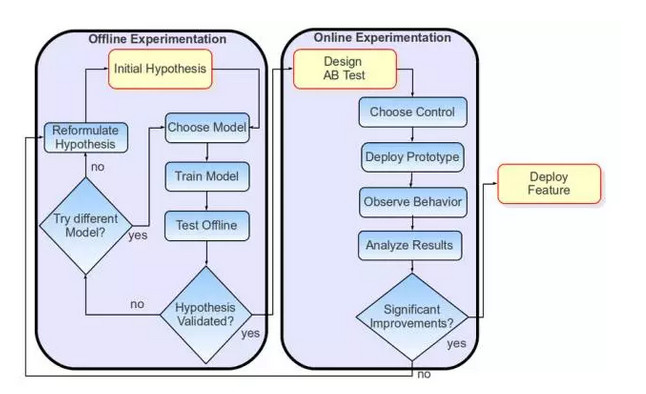

通常，正确的演进路径是这样：

1. 首先提出一个假设，可以通俗的说是对问题的一个猜想；
1. 针对这个假设，我们要选择用什么模型；
1. 模型选定后训练模型，离线测试，如果验证通过就要上AB测试，否则要么换个模型，要么重新审视一下你的假设是不是站得住脚；
1. 上AB测试，测试结果明显提升的话就上线，否则滚回去再看看最开始你那个假设是不是靠谱。

这个过程有几个地方比较难：

第一个就是离线模型评价指标的选择，不同的指标可能包含不同的意义。

例如同样是Learn to rank的排序评价，MRR和NDCG这两个指标对于排序靠前的项目权重就会更大，而FCP（Fraction of Concordant Pairs）就更看重排序靠中间的项目。所以选择什么指标要仔细思考，离线评价表现好才有机会有必要上AB测试。  
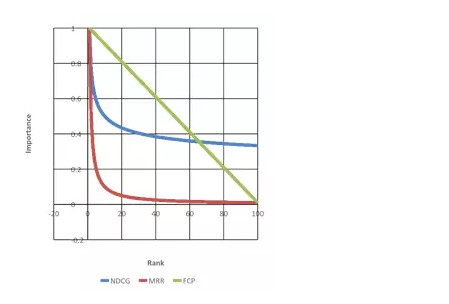

第二个就是离线评价（通常是技术性或者学术性的，比如准确率）和在线产品指标（通常是商业性的，比如留存率）之间通常是存在鸿沟的。模型的离线评价效果可能很好，但是在线去测试，产品指标可能表现不好，可以离线的时候换一个与直接产品指标更相关的评价指标。

第三个就是AB测试的时候一定注意要有一个总体评价指标（ Overall Evaluation Criteria），很多人（通常是产品经理）会同时关注一个AB测试的很多指标，点击率上去了，多样性又下去了，这种测试结果你很难说是该上线还是该下线，所以说需要一个 Overall Evaluation Criteria，如果你有多个目标，就想法把多个目标整合成一个数值指标，这样才能够最终决定AB测试是成功还是失败。 Overall Evaluation Criteria通常是更接近商业目标和平台长期价值的数值，要定义出来需要深度的思考。

最后提一下，AB测试并不是唯一确定新算法是否上线的方式，还有一种方法是bandit算法，见专治选择困难症——bandit算法。

## 十、别一言不合就要上分布式
Hadoop，spark，mapreduce，这些名词背后有一个共同的概念：分布式。

现在，所谓的大数据项目也是言必称分布式，那么是不是都需要分布式呢？尤其是模型部分？老司机Xavier认为，大多数推荐算法不需要分布式，毕竟我们的推荐系统中很少会有训练计算机从海量视频中识别什么是猫这样的算法。

Xavier说，很多算法其实都是可以在单机上完成的（多核的单机），那为什么大家又很少这样做呢？

究其原因有几个：

1. 分布式平台的确降低了处理大数据的门槛，稍微写点胶水代码就可以操作成T上P的数据，工程师们不用懂太多分布式本身的知识；
1. 一些在单机上并行处理数据的方法不为人知，比如像C++中的openmp这样的库，很多人并不知道，它可以充分发挥多核机器的作用。还有Linux本身有很多并行化的命令，比如grep，wc等；
1. 掌握的数据采样方法不够不精。对全量数据采样，以使之在单机上能够计算且不明显损失信息，这是一门精致的手艺，很多人并不掌握。

Xavier说在Quora，曾经用Spark实现了一个计算任务，需要15台机器跑6小时才能跑完，而某个工程师花了四天时间研究spark慢在哪，然后用C++写了一个单机版，只用10分钟就跑完整个任务。说到这里，我也同样的经验，曾经用Spark跑协同过滤，四个小时没有跑完，组内的董玮博士用C++写了一个单机版，用openmp库把所有的核都用上，30分钟就计算完了。

说到这里，常见的推荐算法有很多分布式的库，比如Spark中就有MLib库，但是也可以试试一些著名的单机版，如GraphChi。

